In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  
import matplotlib.pyplot as plt  
import seaborn as sns 

import re  
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

import csv
import requests
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
from sklearn.svm import SVC

from wordcloud import WordCloud

# Loading Dataset

Pada tahap ini dilakukan pengambilan kembali data yang sudah di scrapping dan disimpan pada lokal dengan format .csv data ini merupakan komentar dari salah satu video di platform youtube

In [2]:
df = pd.read_csv("youtube_comments.csv")

In [3]:
df.head(5)

,comment
0,Most wanted ini masih yang terbaik tanpa adany...
1,Sus
2,00:00
3,gw nonton di yahun 2025+bulan ramadan❤
4,2025? :(


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14077 entries, 0 to 14076
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  14077 non-null  object
dtypes: object(1)
memory usage: 110.1+ KB


# Preprocessing Dataset

Pada tahap ini dilakukan penghapusan duplikasi data, membersihkan teks, melakukan penyesuaian text menjadi kecil, melakukan tokenisasi untuk setiap teks, melakukan filterisasi teks, melakukan stemming untuk teks, serta memperbaiki slang words yang terdapat pada dataset

In [5]:
clean_df = df.drop_duplicates()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12337 entries, 0 to 14076
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  12337 non-null  object
dtypes: object(1)
memory usage: 192.8+ KB


In [6]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text) 
    text = re.sub(r'RT[\s]', '', text) 
    text = re.sub(r"http\S+", '', text) 
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text) 


    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

In [7]:
def casefolding(text):
    text = text.lower()
    return text

In [8]:
def tokenizingText(text):
    text = word_tokenize(text)
    return text

In [9]:
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

In [10]:
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text
    
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [11]:
slangwords = {
    'bang': 'abang',
    'bg': 'abang',
    'bwang': 'abang',
    'bng': 'abang',
    'gw': 'saya',
    'gua': 'saya',
    'w': 'saya',
    'yg': 'yang',
    'ga': 'tidak',
    'gk': 'tidak',
    'engga': 'tidak',
    'ngga': 'tidak',
    'gak': 'tidak',
    'lu': 'kamu',
    'bjir' : 'astaga',
    'anjir': 'astaga',
    'anjay': 'astaga',
    'gurinjay': 'astaga',
    'bajay': 'astaga',
    'wanjay': 'astaga',
    'sheeeshhh': 'keren',
    'sory': 'maaf',
    'udh': 'sudah',
    'dah': 'sudah',
    'sdh': 'sudah',
    'lg': 'lagi',
    'lgi': 'lagi',
    'lagii': 'lagi',
    'tp': 'tapi',
    'trs': 'terus',
    'sm': 'sama',
    'tuchhh': 'itu',
    'euy': 'ih',
    'crot': 'keluar',
    'ecek': 'murahan',
    'mlongoo': 'melongo',
    'sagne': 'nafsu',
    'xixixixixi': 'haha',
    'wkwk': 'tertawa',
    'wwkkwkw': 'tertawa',
    'akwkwkwk': 'tertawa',
    'geblek': 'bodoh',
    'anying': 'anjing',
    'njing': 'anjing',
    'sapa': 'siapa',
    'juggaa': 'juga',
    'jt':'juta',
    'sus':'mencurigakan',
    'manntaapp': 'mantap',
    'hlo': 'halo',
    'gay': 'suka lawan jenis',
    'waw': 'tercengang',
    'wow': 'terkejut',
    'ibumum' : 'ibu mu',
    'meme' : 'lelucon',
    'yoi' : 'iya',
    'men' : 'bro',
    'ngakak' : 'tertawa',
    'pw' : 'bayar untuk bermain',
    'dlu' : 'dulu',
    'ny' : 'nya',
    'subscriber' : 'pengikut',
    'perna' : 'pernah',
    'pc' : 'komputer',
    'bocah' : 'anak',
    'bocil' : 'anak kecil',
    'paan' : 'apaan',
    'favorit' : 'kesukaan',
    'jdnya' : 'jadi nya',
    'nnti' : 'nanti',
    'nggak' : 'tidak',
    'gmana' : 'bagaimana',
    'nfs' : 'game balap',
    'ggyt' : 'keren terimakasih',
    'modifannya' : 'kreasi nya',
    'cheat' : 'curang',
    'engine' : 'mesin',
    'ngatain' : 'mengatakan',
    'pake' : 'pakai',
    'hd' : 'jelas',
    'burik' : 'jelek',
    'ad' : 'ada',
    'ff' : 'game peperangan',
    'buriq' : 'jelek',
    'sono' : 'sana',
    'makasih' : 'terimakasih',
    'epictos' : 'terbaik',
    'momentos' : 'momentum',
    'warnet' : 'warung internet',
    'banh' : 'abang',
    'gitu' : 'begitu',
    'esde' : 'sekolah dasar',
    'sd' : 'sekolah dasar',
    'kls' : 'kelas',
    'ko' : 'kok',
    'yaah' : 'iyaa',
    'bnr' : 'benar',
    'emang' : 'memang',
    'wkwkwk' : 'tertawa',
    'link' : 'tautan',
    'tutor' : 'ajarin',
    'thn' : 'tahun',
    'abg' : 'abang',
    'mengkeren' : 'keren',
    'cok' : 'bro',
    'btul' : 'betul',
    'bgt' : 'banget',
    'tamatin' : 'selesaikan',
    'njirt' : 'astaga',
    'jelasss' : 'jelas',
    'donggg' : 'dong',
    'hloo' : 'halo',
    'lho' : 'loh',
    'prime' : 'berjaya',
    'gg' : 'keren',
    'hmmmmm' : 'bergumam',
    'boy' : 'bro',
    'heyy' : 'hai',
    'coy' : 'bro',
    'topup' : 'isi ulang',
    'mntp' : 'mantap',
    'coeyyyy' : 'bro',
    'buff' : 'tingkatkan',
    'jg' : 'juga',
    'ya' : 'iya',
    'goreng' : 'katain',
    'plis' : 'mohon',
    'gelo' : 'gila',
    'branda' : 'beranda',
    'yutub' : 'youtube',
    'montage' : 'edit',
    'yng' : 'yang',
    'nntnnya' : 'nonton nya',
    'gue' : 'saya',
    'lur' : 'bro',
    'ps 2' : 'video game 2',
    'ps2' : 'video game 2',
    'wkwkwkwk' : 'haha',
    'ps3' : 'video game 3',
    'kek' : 'sepertinya',
    'plies' : 'mohon',
    'viewer' : 'penonton',
    'oon' : 'bodoh',
    'gituan' : 'seperti itu',
    'guys' : 'teman teman',
    'v' : 'tertawa',
    'yahun' : 'tahun',
    'subcriber' : 'pengikut',
    'bangv' : 'abang tertawa',
    'love' : 'suka',
    'wanted' : 'game balap',
    'wak' : 'bro',
    'razor' : 'pembalap lawan',
    'cobalt' : 'mobil balap',
    'blacklist' : 'ranking',
    'bounty' : 'uang',
    'bangg' : 'abang',
    'pliss' : 'mohon',
    'inii' : 'ini',
    'sory' : 'maaf',
    'trakhir' : 'terakhir',
    'auto' : 'otomatis',
    'crash' : 'rusak',
    'ngebug' : 'error',
    'hbs' : 'habis',
    'an jayyy' : 'astaga',
    'anjayyyyy' : 'astaga',
    'enggak' : 'tidak',
    'G' : 'tidak',
    'kek' : 'sepertinya',
    'cuy' : 'bro',
    'th' : 'tahun',
    'dh' : 'sudah',
    'dtk' : 'detik',
    'bocil kematian' : 'penonton rusuh',
    'fc' : 'keluar secara terpaksa',
    'dpt' : 'dapat',
    'dri' : 'dari',
    'gada' : 'tidak ada',
    'pnya' : 'punya',
    'user' : 'pengguna',
    'sub' : 'pengikut',
    'ramadan' : 'ramadhan',
}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [12]:
clean_df

,comment
0,Most wanted ini masih yang terbaik tanpa adany...
1,Sus
2,00:00
3,gw nonton di yahun 2025+bulan ramadan❤
4,2025? :(
...,...
14069,Love Bang:v
14070,Anjayyyyy :v
14071,first
14074,1 jt subcriber bang amin🤘🏼🤘🏼


In [13]:
clean_df['text_clean'] = clean_df['comment'].apply(cleaningText)

clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefolding)

clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [14]:
clean_df

,comment,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Most wanted ini masih yang terbaik tanpa adany...,Most wanted ini masih yang terbaik tanpa adany...,most wanted ini masih yang terbaik tanpa adany...,most game balap ini masih yang terbaik tanpa a...,"[most, game, balap, ini, masih, yang, terbaik,...","[game, balap, terbaik, anak, bayar, bermain, a...",game balap terbaik anak bayar bermain anak che...
1,Sus,Sus,sus,mencurigakan,[mencurigakan],[mencurigakan],mencurigakan
2,00:00,,,,[],[],
3,gw nonton di yahun 2025+bulan ramadan❤,gw nonton di yahun bulan ramadan,gw nonton di yahun bulan ramadan,saya nonton di tahun bulan ramadhan,"[saya, nonton, di, tahun, bulan, ramadhan]","[nonton, ramadhan]",nonton ramadhan
4,2025? :(,,,,[],[],
...,...,...,...,...,...,...,...
14069,Love Bang:v,Love Bangv,love bangv,suka abang tertawa,"[suka, abang, tertawa]","[suka, abang, tertawa]",suka abang tertawa
14070,Anjayyyyy :v,Anjayyyyy v,anjayyyyy v,astaga tertawa,"[astaga, tertawa]","[astaga, tertawa]",astaga tertawa
14071,first,first,first,first,[first],[first],first
14074,1 jt subcriber bang amin🤘🏼🤘🏼,jt subcriber bang amin,jt subcriber bang amin,juta pengikut abang amin,"[juta, pengikut, abang, amin]","[juta, pengikut, abang, amin]",juta pengikut abang amin


# Labeling

In [15]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')


    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [16]:
def analisis_sentimen_lexicon_indonesia(text):
    total_skor = 0

    for kata in text:
        if kata in lexicon_positive:
            total_skor += lexicon_positive[kata]
        elif kata in lexicon_negative:
            total_skor += lexicon_negative[kata]

    if total_skor > 0:
        label_sentimen = 'positive'
    elif total_skor < 0:
        label_sentimen = 'negative'
    else:
        label_sentimen = 'neutral'

    return total_skor, label_sentimen

In [17]:
results = clean_df['text_stopword'].apply(analisis_sentimen_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    5633
neutral     3770
negative    2934
Name: count, dtype: int64


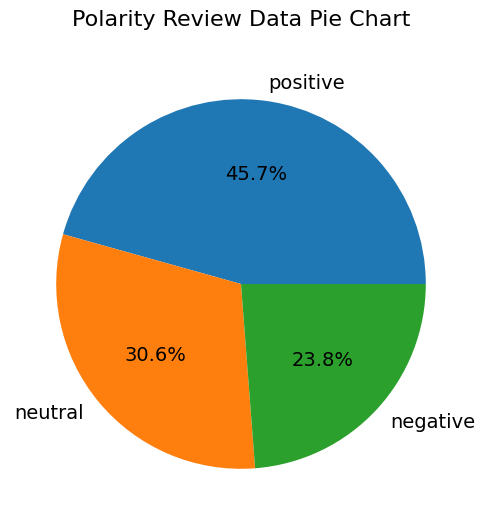

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in clean_df['polarity'].value_counts()]


labels = list(clean_df['polarity'].value_counts().index)

ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14})

ax.set_title('Polarity Review Data Pie Chart', fontsize=16, pad=20)

plt.show()

In [19]:
pd.set_option('display.max_colwidth', 5000)

positive_tweets = clean_df[clean_df['polarity'] == 'positive']

positive_tweets = positive_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

positive_tweets = positive_tweets.sort_values(by='polarity_score', ascending=False)

positive_tweets = positive_tweets.reset_index(drop=True)

positive_tweets.index += 1

In [20]:
pd.set_option('display.max_colwidth', 5000)

negative_tweets = clean_df[clean_df['polarity'] == 'negative']

negative_tweets = negative_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

negative_tweets = negative_tweets.sort_values(by='polarity_score', ascending=True)

negative_tweets = negative_tweets[0:10]

negative_tweets = negative_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
negative_tweets.index += 1

In [21]:
pd.set_option('display.max_colwidth', 5000)

neutral_tweets = clean_df[clean_df['polarity'] == 'neutral']

neutral_tweets = neutral_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]

neutral_tweets = neutral_tweets.sort_values(by='polarity_score', ascending=True)

neutral_tweets = neutral_tweets[0:10]

neutral_tweets = neutral_tweets.reset_index(drop=True)

neutral_tweets.index += 1

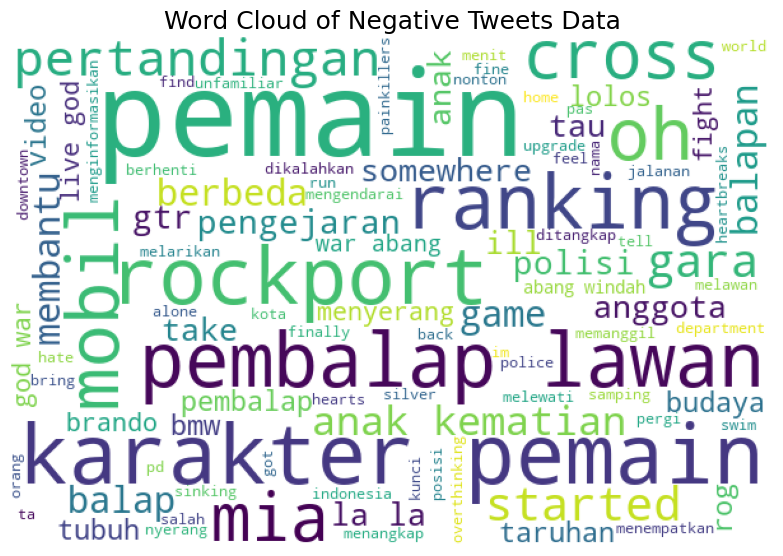

In [22]:
list_words = ''

for tweet in negative_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('Word Cloud of Negative Tweets Data', fontsize=18)

ax.grid(False)

ax.imshow((wordcloud))

fig.tight_layout(pad=0)

ax.axis('off')

plt.show()

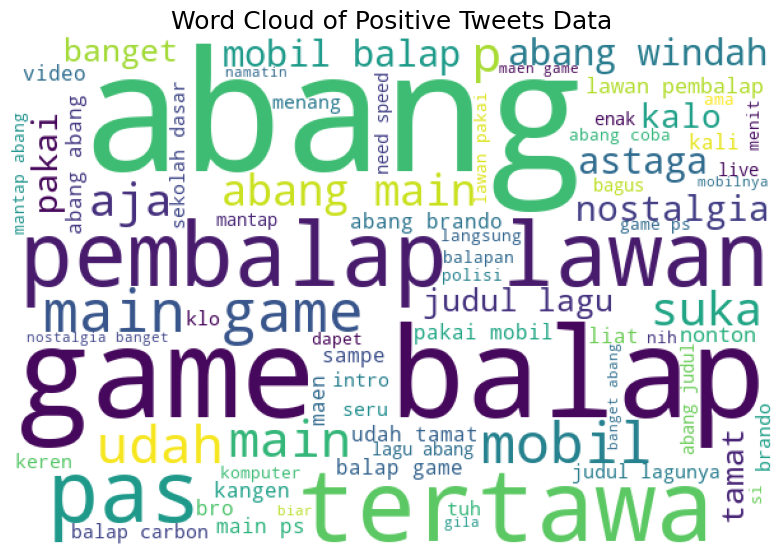

In [23]:
list_words = ''

for tweet in positive_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)


wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)


fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('Word Cloud of Positive Tweets Data', fontsize=18)

ax.grid(False)

ax.imshow((wordcloud))

fig.tight_layout(pad=0)

ax.axis('off')

plt.show()

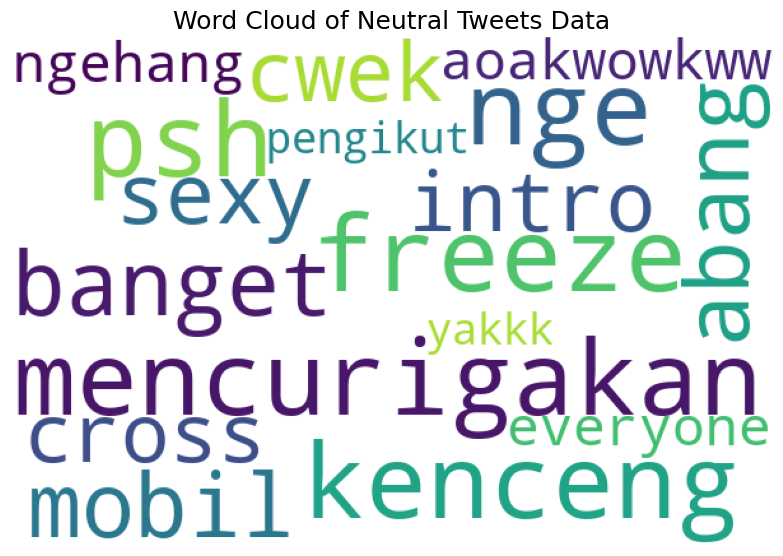

In [24]:
list_words = ''

for tweet in neutral_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title('Word Cloud of Neutral Tweets Data', fontsize=18)

ax.grid(False)

ax.imshow((wordcloud))

fig.tight_layout(pad=0)

ax.axis('off')

plt.show()

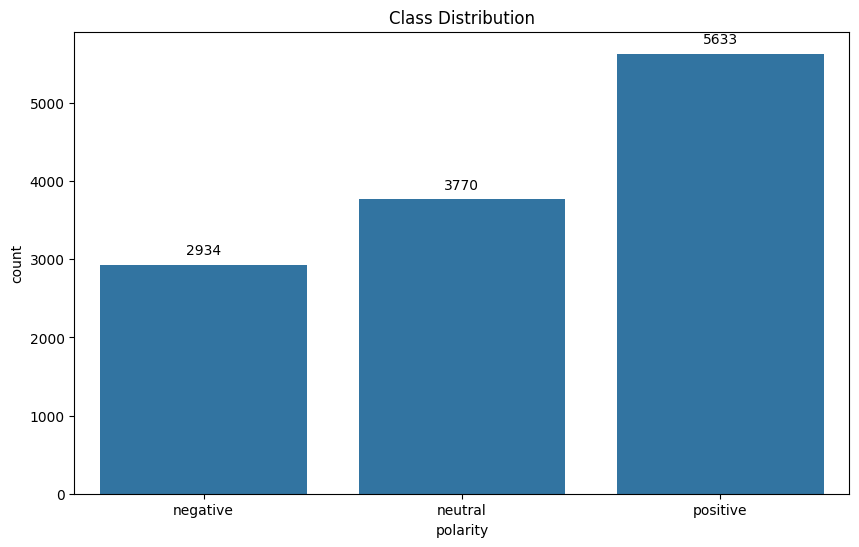

In [25]:
plt.figure(figsize=(10, 6))

class_dist_plot = sns.countplot(x='polarity', data=clean_df)
plt.title('Class Distribution')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')

plt.show()

# Data Splitting

Pada tahap ini dilakukan splitting data untuk dilakukan pengujian serta pelatihan data

In [26]:
clean_df

,comment,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
0,Most wanted ini masih yang terbaik tanpa adanya bocil p2w tanpa ada bocil cheater dan tanpa ada bocil android\nMost wanted redux mengecewakan :(,Most wanted ini masih yang terbaik tanpa adanya bocil pw tanpa ada bocil cheater dan tanpa ada bocil android Most wanted redux mengecewakan,most wanted ini masih yang terbaik tanpa adanya bocil pw tanpa ada bocil cheater dan tanpa ada bocil android most wanted redux mengecewakan,most game balap ini masih yang terbaik tanpa adanya anak kecil bayar untuk bermain tanpa ada anak kecil cheater dan tanpa ada anak kecil android most game balap redux mengecewakan,"[most, game, balap, ini, masih, yang, terbaik, tanpa, adanya, anak, kecil, bayar, untuk, bermain, tanpa, ada, anak, kecil, cheater, dan, tanpa, ada, anak, kecil, android, most, game, balap, redux, mengecewakan]","[game, balap, terbaik, anak, bayar, bermain, anak, cheater, anak, android, game, balap, redux, mengecewakan]",game balap terbaik anak bayar bermain anak cheater anak android game balap redux mengecewakan,-2,negative
1,Sus,Sus,sus,mencurigakan,[mencurigakan],[mencurigakan],mencurigakan,0,neutral
2,00:00,,,,[],[],,0,neutral
3,gw nonton di yahun 2025+bulan ramadan❤,gw nonton di yahun bulan ramadan,gw nonton di yahun bulan ramadan,saya nonton di tahun bulan ramadhan,"[saya, nonton, di, tahun, bulan, ramadhan]","[nonton, ramadhan]",nonton ramadhan,0,neutral
4,2025? :(,,,,[],[],,0,neutral
...,...,...,...,...,...,...,...,...,...
14069,Love Bang:v,Love Bangv,love bangv,suka abang tertawa,"[suka, abang, tertawa]","[suka, abang, tertawa]",suka abang tertawa,8,positive
14070,Anjayyyyy :v,Anjayyyyy v,anjayyyyy v,astaga tertawa,"[astaga, tertawa]","[astaga, tertawa]",astaga tertawa,8,positive
14071,first,first,first,first,[first],[first],first,0,neutral
14074,1 jt subcriber bang amin🤘🏼🤘🏼,jt subcriber bang amin,jt subcriber bang amin,juta pengikut abang amin,"[juta, pengikut, abang, amin]","[juta, pengikut, abang, amin]",juta pengikut abang amin,5,positive


In [27]:
X = clean_df['text_akhir']
y = clean_df['polarity']

# Ekstrasi Fitur dengan TF-IDF

In [73]:
tfidf = TfidfVectorizer(max_features=500, min_df=10, max_df=0.5)
X_tfidf = tfidf.fit_transform(X)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=128)

# Modeling dengan Random Forest Classifier, Logistic Regression & SVC

Modeling ini dilakukan dengan 2 Klasifikasi yaitu Random Forest, Logistic Regression & SVC menggunakan ekstraksi fitur dengan TF-IDF

In [75]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train.toarray(), y_train)

y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 0.9528827642111662
Random Forest - accuracy_test: 0.8541329011345219


In [76]:
logistic_regression = LogisticRegression()

logistic_regression.fit(X_train.toarray(), y_train)

y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.8881345627723174
Logistic Regression - accuracy_test: 0.8743922204213939


In [77]:
support_vector_classifier = SVC()

support_vector_classifier.fit(X_train.toarray(), y_train)

y_pred_train_svc = support_vector_classifier.predict(X_train.toarray())
y_pred_test_svc = support_vector_classifier.predict(X_test.toarray())

accuracy_train_svc = accuracy_score(y_pred_train_svc, y_train)

accuracy_test_svc = accuracy_score(y_pred_test_svc, y_test)

print('Support Vector Classifier - accuracy_train:', accuracy_train_svc)
print('Support Vector Classifier - accuracy_test:', accuracy_test_svc)

Support Vector Classifier - accuracy_train: 0.9200526902421725
Support Vector Classifier - accuracy_test: 0.8711507293354943


In [61]:
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'Support Vector Classifier'],
    'Accuracy Train': [accuracy_train_rf, accuracy_train_lr,accuracy_train_svc],
    'Accuracy Test': [accuracy_test_rf, accuracy_test_lr,accuracy_test_svc]
})
accuracy_test_only = results_df[['Model', 'Accuracy Test']]
print(accuracy_test_only)

                       Model  Accuracy Test
0              Random Forest       0.853728
1        Logistic Regression       0.874392
2  Support Vector Classifier       0.871151


# Ekstraksi Fitur dengan Word2VEC

In [45]:
w2v = Word2Vec(sentences=X, vector_size=300, window=5, min_count=3, workers=4)

In [46]:
def get_sentence_vector(sentence, model):
    vectors = []
    for word in sentence:
        if word in model.wv:
            vectors.append(model.wv[word])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

X_vector = np.array([get_sentence_vector(sentence, w2v) for sentence in X])

# Modeling dengan SVC dan Logistic Regression dengan data splitting 60/40

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_vector, y, test_size=0.4, random_state=42)

In [36]:
support_vector_classifier = SVC()

support_vector_classifier.fit(X_train, y_train)

y_pred_train_svc = support_vector_classifier.predict(X_train)
y_pred_test_svc = support_vector_classifier.predict(X_test)

accuracy_train_svc = accuracy_score(y_pred_train_svc, y_train)

accuracy_test_svc = accuracy_score(y_pred_test_svc, y_test)

print('Support Vector Classifier - accuracy_train:', accuracy_train_svc)
print('Support Vector Classifier - accuracy_test:', accuracy_test_svc)

Support Vector Classifier - accuracy_train: 0.6706295595784924
Support Vector Classifier - accuracy_test: 0.6690982776089159


# Modeling dengan Random Forest Classifier dan data splitting 80/20

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_vector, y, test_size=0.2, random_state=42)

In [52]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

y_pred_train_rf = random_forest.predict(X_train)
y_pred_test_rf = random_forest.predict(X_test)

accuracy_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_test_rf = accuracy_score(y_pred_test_rf, y_test)

print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 1.0
Random Forest - accuracy_test: 0.7188006482982172


In [115]:
kalimat_baru = input("Masukkan kalimat baru: ")

kalimat_baru_cleaned = cleaningText(kalimat_baru)
kalimat_baru_casefolded = casefolding(kalimat_baru_cleaned)
kalimat_baru_slangfixed = fix_slangwords(kalimat_baru_casefolded)
kalimat_baru_tokenized = tokenizingText(kalimat_baru_slangfixed)
kalimat_baru_filtered = filteringText(kalimat_baru_tokenized)
kalimat_baru_final = toSentence(kalimat_baru_filtered)

X_kalimat_baru = tfidf.transform([kalimat_baru_final])

prediksi_sentimen = logistic_regression.predict(X_kalimat_baru)

if prediksi_sentimen[0] == 'positive':
    print("Sentimen kalimat baru adalah POSITIF.")
else:
    print("Sentimen kalimat baru adalah NEGATIF.")

Masukkan kalimat baru:  hebat keren gamenya terbaik


Sentimen kalimat baru adalah POSITIF.


In [3]:
!pip freeze > requirements.txt